# Topic Analysis

In [1]:
# Export requirements.txt for only the packages used in this notebook
# pip install pipreqs
# !pipreqs --force .
from sklearnex import patch_sklearn
patch_sklearn()
import pandas as pd, glob, os, sys, win32com.client, pythoncom, numpy as np, re, seaborn as sns, matplotlib.pyplot as plt, warnings, time, pickle
from filesplit.split import Split
from filesplit.merge import Merge

from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier, VotingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from lightgbm import LGBMClassifier

warnings.filterwarnings("ignore")
set_config(display='diagram')
# dir_path = os.path.dirname(os.path.realpath(sys.argv[0])) + "\\"
dir_path = os.getcwd() + "\\"

def set_options(xl, option):
    try:
        xl.Visible = option
        xl.ScreenUpdating = option
        xl.DisplayAlerts = option
        xl.EnableEvents = option
    except: 
        pass

def convert(file):
    file = os.path.splitext(file)[0]
    print('Converting {}...'.format(file))
    xl=win32com.client.Dispatch("Excel.Application",pythoncom.CoInitialize())
    set_options(xl, False)
    
    # check if file with .csv exists
    if not os.path.isfile(dir_path + file + '.csv'):
        try:
            wb = xl.Workbooks.Open(Filename= dir_path + file + '.xlsx',ReadOnly=1)
        except:
            wb = xl.Workbooks.Open(Filename= dir_path + file + '.xlsb',ReadOnly=1)  
        xl.ActiveWorkbook == wb
        
        #6 means csv
        wb.SaveAs(Filename= dir_path + file + '.csv', FileFormat='6') 
        set_options(xl, True)
        wb.Close(True)
        xl.Application.Quit()
        wb=xl=None
    
    df = pd.read_csv(dir_path + file + '.csv', low_memory = False, encoding='ISO-8859-1')
    df.to_pickle(dir_path + file + '.pkl')
    
    return file + '.pkl'

def read(i):
    try: 
        pkl = glob.glob(os.path.join('*{0}*.pkl'.format(i)))[0]
    except: 
        pkl = convert(glob.glob(os.path.join('*{0}*'.format(i)))[0])
    df = pd.read_pickle(dir_path + pkl)
    return df

# Custom function to store models
def pickle_split(filename, model):
    file = filename + '.mgz'
    pickle.dump(model, open(file, 'wb'))

    # Check file size
    print('File Size: {:.2f} {}'.format(os.path.getsize(file)/1000000, 'MB'))

    # Split stack.mgz into 99 MB parts using filesplit
    split = Split(inputfile=file, outputdir='.')
    split.manfilename = filename
    split.bysize(size=100000000)
    os.remove(file)

def merge_pickle(filename):
    # Merge the files back together
    filepath = filename + '.mgz'
    merge = Merge(inputdir='.', outputdir='.', outputfilename=filepath)
    merge.manfilename = filename
    merge.merge()

    # Load the model
    file = pickle.load(open(filepath, 'rb'))
    os.remove(filepath)
    return file

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


ModuleNotFoundError: No module named 'filesplit'

In [ ]:
# Pickle dataset, delete resume.pkl if you are facing issues
i = "Resume"
df = read(i)

df.head()

In [ ]:
# Remove Resume_html and ID
df.drop(['Resume_html', 'ID'], axis=1, inplace=True)
df.columns = ['text', 'label']

df.head()

In [ ]:
# Clean text
df['text'] = [re.sub('</?([a-z]+)>', ' ', x) for x in df['text']] 
df['text'] = [re.sub('<[^>]*>', '', x) for x in df['text']] 
df['text'] = [re.sub('\s+', ' ', x) for x in df['text']] 
df['text'] = [x.lower() for x in df['text']] # lowercase

df.head()

In [75]:
#6 obtain the processed tokenized comments
docs_resume = corpus2docs(df_resume['text'])

In [ ]:
#7 add pos tags and leave nouns 
https://textblob.readthedocs.io/en/dev/quickstart.html#noun-phrase-extraction

In [76]:
#7b extra: check most common words of cleaned text
flattened_docs1 = [y for x in docs_resume for y in x]
fdocs1 = nltk.FreqDist(flattened_docs1)
print(fdocs1.most_common(100))

[("'manag", 24362), ("'state", 16806), ("'compani", 15728), ("'citi", 15129), ("'develop", 12110), ("'name", 11792), ("'custom", 11738), ("'servic", 9203), ("'work", 8854), ("'skill", 8739), ("'account", 8652), ("'sale", 8535), ("'busi", 8170), ("'project", 8073), ("'product", 7510), ("'train", 7275), ("'system", 7261), ("'team", 7146), ("'process", 6912), ("'commun", 6896), ("'ï¼", 6890), ("'new", 6633), ("'plan", 6509), ("'client", 6494), ("'market", 6255), ("'report", 6203), ("'provid", 6170), ("'oper", 6136), ("'includ", 6125), ("'design", 6094), ("'assist", 6068), ("'maintain", 5999), ("'experi", 5841), ("'program", 5546), ("'perform", 5416), ("'us", 5227), ("'support", 5150), ("'offic", 5114), ("'educ", 5100), ("'inform", 4882), ("'prepar", 4557), ("'implement", 4437), ("'respons", 4398), ("'profession", 4370), ("'employe", 4369), ("'financi", 4363), ("'administr", 4009), ("'time", 3960), ("'creat", 3954), ("'staff", 3945), ("'ensur", 3903), ("'excel", 3817), ("'data", 3785), ("'

In [37]:
#8 create dictionary and corpus needed for topic modeling
# Create Dictionary 
id2word = corpora.Dictionary(docs_resume)

# Term Document Frequency for corpus
corpus = docs2vecs(docs_resume, id2word)

In [38]:
## CAN REMOVE??

#9 build LDA Mallet models and compute coherennce score ## Mallet model has no function to compute perplexity score
print(datetime.datetime.now())

mbefore_model_list = []
mbefore_coherence_values = []
mbefore_model_topics = []

for num_topics in range(2, 16):
    ldamallet_before = gensim.models.wrappers.LdaMallet(mallet_path,
                                                        corpus=corpus, 
                                                        iterations=500, 
                                                        num_topics=num_topics, 
                                                        id2word=id2word,
                                                        random_seed=123)
    
    # calculate coherence
    coherence_model_mallet_b4 = CoherenceModel(model=ldamallet_before, 
                                               texts=docs_resume, 
                                               dictionary=id2word, 
                                               coherence='c_v')
    coherence_ldamallet_b4 = coherence_model_mallet_b4.get_coherence()
    
    # record all results into lists
    mbefore_model_topics.append(num_topics)
    mbefore_model_list.append(ldamallet_before)
    mbefore_coherence_values.append(coherence_ldamallet_b4)
    
    print("#Topics: " + str(num_topics) + " Coherence Score: " + str(coherence_ldamallet_b4))
    
    top_words_per_topic_mb4 = []
    for t in range(ldamallet_before.num_topics):
        top_words_per_topic_mb4.extend([(t, ) + x for x in ldamallet_before.show_topic(t, topn = 10)])
    pd.DataFrame(top_words_per_topic_mb4, columns=['Topic', 'Word', 'P']).to_csv('./mallet_top_words/' + str(num_topics) + "_topics_top_words_before.csv")

print(datetime.datetime.now())

2022-10-17 20:17:17.535509
#Topics: 2 Coherence Score: 0.41615535787850266
#Topics: 3 Coherence Score: 0.3999719866996159
#Topics: 4 Coherence Score: 0.4020697108150533
#Topics: 5 Coherence Score: 0.42550427190925105
#Topics: 6 Coherence Score: 0.42086441359429494
#Topics: 7 Coherence Score: 0.42308951871546985
#Topics: 8 Coherence Score: 0.4304137788793977
#Topics: 9 Coherence Score: 0.4441602199455649
#Topics: 10 Coherence Score: 0.41799658864621153
#Topics: 11 Coherence Score: 0.4358037560946357
#Topics: 12 Coherence Score: 0.4537967764408566
#Topics: 13 Coherence Score: 0.45060146706895654
#Topics: 14 Coherence Score: 0.44155287337776455
#Topics: 15 Coherence Score: 0.44172307055894017
2022-10-17 20:23:27.500293


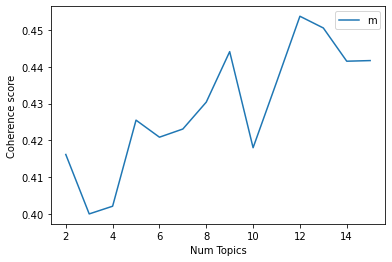

In [39]:
# 10 plot coherence score
plt.plot(mbefore_model_topics, mbefore_coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("mbefore_coherence_values"), loc='best')
plt.show()

In [40]:
#11 print words in topic
pprint(mbefore_model_list[8].print_topics(num_topics=10, num_words=10))

[(0,
  '0.049*"\'children" + 0.046*"\'activ" + 0.019*"\'child" + 0.019*"\'educ" + '
  '0.019*"\'behavior" + 0.016*"\'parent" + 0.016*"\'daili" + 0.014*"\'teacher" '
  '+ 0.013*"\'maintain" + 0.012*"\'citi"'),
 (1,
  '0.027*"\'student" + 0.027*"\'provid" + 0.020*"\'plan" + 0.018*"\'standard" '
  '+ 0.017*"\'project" + 0.016*"\'progress" + 0.015*"\'skill" + '
  '0.014*"\'support" + 0.014*"\'techniqu" + 0.014*"\'social"'),
 (2,
  '0.054*"\'state" + 0.043*"\'citi" + 0.039*"\'compani" + 0.035*"\'teacher" + '
  '0.034*"\'name" + 0.033*"\'work" + 0.028*"\'skill" + 0.025*"\'assist" + '
  '0.023*"\'administr" + 0.021*"\'meet"'),
 (3,
  '0.044*"\'custom" + 0.025*"\'servic" + 0.022*"\'maintain" + '
  '0.021*"\'compani" + 0.020*"\'sale" + 0.019*"\'ï¼" + 0.019*"\'area" + '
  '0.018*"\'manag" + 0.017*"\'state" + 0.016*"\'work"'),
 (4,
  '0.031*"\'scienc" + 0.025*"\'compani" + 0.024*"\'patient" + '
  '0.021*"\'perform" + 0.019*"\'state" + 0.019*"\'skill" + 0.018*"\'univers" + '
  '0.016*"\'teacher" +

In [41]:
#12 visualize the 10 topics
mmodel_b4 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mbefore_model_list[8])

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(mmodel_b4, corpus, id2word)
vis

C:\Users\jovinkahartanto\AppData\Roaming\Python\Python38\site-packages\pandas\core\internals\blocks.py:352: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\jovinkahartanto\AppData\Roaming\Python\Python38\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
C:\Users\jovinkahartanto\AppData\Roaming\Python\Python38\site-packages\pandas\core\internals\blocks.py:352: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.292463 -0.068046       1        1  15.388113
7     -0.048832 -0.126966       2        1  11.910541
0     -0.066188 -0.052197       3        1  11.655096
2      0.053285  0.188023       4        1  10.472784
1     -0.184457  0.204695       5        1  10.395660
8     -0.054830 -0.252522       6        1   9.869263
9      0.268243 -0.158742       7        1   9.296584
3      0.151440  0.070679       8        1   8.573467
5     -0.000030  0.101779       9        1   7.131936
4      0.173832  0.093296      10        1   5.306556, topic_info=          Term         Freq        Total Category  logprob  loglift
249   'student  1089.000000  1089.000000  Default  30.0000  30.0000
373  'children   300.000000   300.000000  Default  29.0000  29.0000
83       'educ   641.000000   641.000000  Default  28.0000  28.0000
245     'state   744.000000   744.000000  Default  27.0000  27.0000
3       'activ   310.000000   310.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
259     'teach    26.541865   272.772063  Topic10  -4.6551   0.6063
122    'includ    21.233492   128.524310  Topic10  -4.8782   1.1357
424      'keep    18.048468    65.469231  Topic10  -5.0408   1.6477
35    'certifi    16.986793    48.327137  Topic10  -5.1014   1.8907
92     'experi    19.110143   228.343491  Topic10  -4.9836   0.4556

[828 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
875       1  1.026603   'absenc
497       2  1.000375   'academ
1122      6  0.993051  'academi
357       3  1.021048   'access
0         5  1.003324   'accord
...     ...       ...       ...
496       3  1.021048      'zoo
287       2  0.479007       'ï¼
287       3  0.144910       'ï¼
287       8  0.346173       'ï¼
287       9  0.028177       'ï¼

[1119 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 8, 1, 3, 2, 9, 10, 4, 6, 5])

In [42]:
#13 Save the output to the html file
pyLDAvis.save_html(vis, "ldamallet_before_10topics.html")

In [43]:
#14 Save the LDA mallet model with 10 topics
mallet_before_10topics = mbefore_model_list[8]
mallet_before_10topics.save("mallet_before_10topics")

# mallet_before = gensim.models.wrappers.LdaMallet.load("mallet_before_10topics")

In [44]:
#15 Find most dominant topic

def format_topics_sentences(ldamodel, corpus, data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(data)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [45]:
#16 Output dominant topics for each post
df_topic_sents_keywords = format_topics_sentences(ldamodel=mbefore_model_list[8], corpus=corpus, data=docs_resume)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

<ipython-input-44-9b3c5fb3043c>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4,0.3083,"'scienc, 'compani, 'patient, 'perform, 'state,...","['biologi, 'teacher, 'experi, 'current, 'biolo..."
1,1,3,0.2211,"'custom, 'servic, 'maintain, 'compani, 'sale, ...","['substitut, 'teacher, 'skill, 'outlook, 'exce..."
2,2,0,0.5935,"'children, 'activ, 'child, 'educ, 'behavior, '...","['master, 'teacher, 'highlight, 'home, 'school..."
3,3,0,0.2786,"'children, 'activ, 'child, 'educ, 'behavior, '...","['lead, 'teacher, 'summari, 'secur, 'posit, 'u..."
4,4,5,0.2427,"'design, 'skill, 'oper, 'necessari, 'current, ...","['guest, 'teacher, 'profession, 'overview, 'de..."
5,5,6,0.2920,"'student, 'classroom, 'lesson, 'learn, 'teache...","['classroom, 'teacher, 'profession, 'summari, ..."
6,6,1,0.2227,"'student, 'provid, 'plan, 'standard, 'project,...","['teacher, 'profession, 'summari, 'master, 'te..."
7,7,8,0.2516,"'program, 'manag, 'commun, 'develop, 'team, 'y...","['substitut, 'teacher, 'summari, 'receiv, 'edu..."
8,8,4,0.4751,"'scienc, 'compani, 'patient, 'perform, 'state,...","['teacher, 'farrah, 'bauman, 'profession, 'sum..."
9,9,7,0.3690,"'educ, 'state, 'citi, 'teacher, 'parent, 'ï¼, ...","['teacher, 'summari, 'experienc, 'detail, 'ori..."


In [46]:
#17 Merge with original dataset (excluding ring)
before_with_dominant = pd.concat([df_before, df_dominant_topic], axis=1)
before_with_dominant

NameError: name 'df_before' is not defined

In [ ]:
#18 Save original posts with dominant topics
before_with_dominant.to_csv('dominant topics_before.csv', index = False)

# Entity Analysis

In [104]:
nlp = spacy.load("en_core_web_lg")
skill_pattern_path = "convertjson.jsonl"

In [105]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_pattern_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [114]:
df = pd.read_csv("Resume.csv")
df = df.reindex(np.random.permutation(df.index))
df_filter = df

In [116]:
ruler.add_patterns([{"label": "Job-Category", "pattern": a}])
# options=[{"ents": "Job-Category", "colors": "#ff3232"},{"ents": "SKILL", "colors": "#56c426"}]
colors = {
    "Job-Category": "linear-gradient(90deg, #aa9cfc, #fc9ce7)",
    "SKILL": "linear-gradient(90deg, #9BE15D, #00E3AE)",
    "ORG": "#ffd966",
    "PERSON": "#e06666",
    "GPE": "#9fc5e8",
    "DATE": "#c27ba0",
    "ORDINAL": "#674ea7",
    "PRODUCT": "#f9cb9c",
}
options = {
    "ents": [
        "Job-Category",
        "SKILL",
        "ORG",
        "PERSON",
        "GPE",
        "DATE",
        "ORDINAL",
        "PRODUCT",
    ],
    "colors": colors,
}
sent = nlp(df_filter["Resume_str"].iloc[5])
displacy.render(sent, style="ent", jupyter=True, options=options)